In [6]:
import numpy as np
from scipy.stats import norm, invwishart, multivariate_normal
import pdb
import sys
sys.path.append('../')
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, roc_auc_score

def train_test_split(X, y, test_fraction=0.2, seed=10):
    n = X.shape[0]
    np.random.seed(seed)
    idx = np.random.permutation(n)
    idx_val = idx[0:int(0.5*test_fraction*n)]
    idx_te = idx[int(0.5*test_fraction*n):int(test_fraction*n)]
    idx_tr = idx[int(test_fraction * n):]
    return X[idx_tr, :], y[idx_tr], X[idx_val, :], y[idx_val], X[idx_te, :], y[idx_te], idx_tr, idx_te

def sample_batch(X, y, batch_size=1000):
    idx = np.random.permutation(X.shape[0])[:batch_size]
    return X[idx, :], y[idx, :]


def regression_metrics(true, predicted):
    r2 = r2_score(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    return r2, rmse

def classification_metrics(true, predicted):
    #tn, fp, fn, tp = confusion_matrix(true, predicted).ravel()
    roc_auc = roc_auc_score(true, predicted)
    #precision = tp / (tp + fp)
    #recall = tp / (tp + fn)
    
    return roc_auc#, precision, recall
    

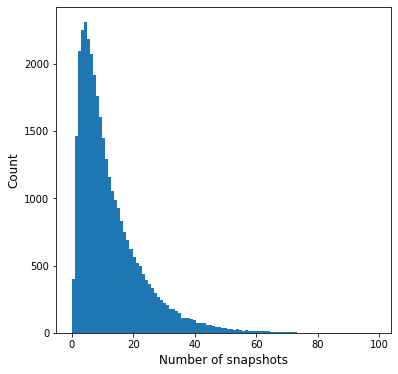

In [15]:
fontsize = 12

path = '../data/processed/'
X = np.load(path + 'X_6_new.npy')
y_reg = np.load(path + 'y_6_new.npy')


fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(y_reg, bins=100)
ax.set_xlabel('Number of snapshots', fontsize=fontsize)
ax.set_ylabel('Count', fontsize=fontsize)
fig.savefig('histogram-6.png', dpi=400)
#Counter(y_reg)

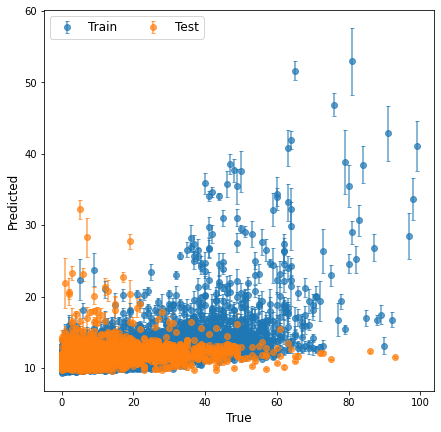

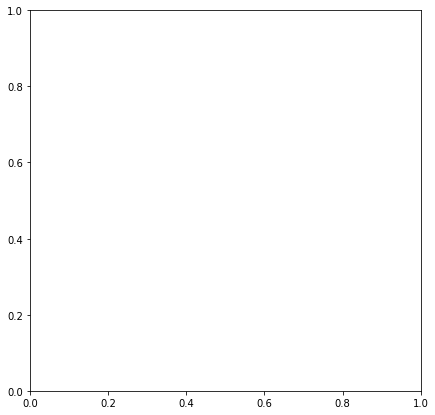

In [18]:
n_ensembles = 5
fontsize = 12
max_depth = 15

seeds = [10, ]
start_seed = 2

for seed in seeds:
    np.random.seed(seed)
    
    X_train, y_train, X_val, y_val, X_test, y_test, _, _ = train_test_split(X, y, seed=seed+10)
    
    ensemble_states = np.arange(1, n_ensembles + 1, 1)

    means = []
    vars = []
    benchmark = []

    fig, ax = plt.subplots(1, 1, figsize=(7, 7))

    y_pred_trs = []
    y_pred_tes = []

    # Random forest model. Different set of random seeds for each train/test split.
    states = n_ensembles*ensemble_states + start_seed
    for ensemble_state in states:
        regr = RandomForestRegressor(max_depth=max_depth, random_state=ensemble_state)
        regr.fit(X_train, y_train)

        # Make predictions
        y_pred_tr = regr.predict(X_train)
        y_pred_trs.append(y_pred_tr)
        y_pred_te = regr.predict(X_test)
        y_pred_tes.append(y_pred_te)

    y_pred_trs = np.vstack(y_pred_trs)
    y_pred_tes = np.vstack(y_pred_tes)
    y_pred_tr = np.mean(y_pred_trs, axis=0)
    y_pred_tr_err = np.var(y_pred_trs, axis=0)
    y_pred_te = np.mean(y_pred_tes, axis=0)
    y_pred_te_err = np.var(y_pred_tes, axis=0)

    ax.errorbar(y_train, y_pred_tr, yerr=np.sqrt(y_pred_tr_err), marker='o', alpha=0.7, linestyle='', capsize=2.0, label='Train')    
    ax.errorbar(y_test, y_pred_te, yerr=np.sqrt(y_pred_te_err), marker='o', alpha=0.7, linestyle='', capsize=2.0, label='Test')

    ax.set_xlabel('True', fontsize=fontsize)
    ax.set_ylabel('Predicted', fontsize=fontsize)
    ax.legend(fontsize=fontsize, ncol=2)
    fig.savefig('rf-regression{}.png'.format(seed), dpi=400)

In [19]:
regression_metrics(y_test, y_pred_te)

(0.0014035209269741555, 10.669544681897596)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

class VanillaNN(nn.Module):
    """
    A `vanilla` neural network.
    """

    def __init__(self, in_dim, out_dim, hidden_dims, non_linearity=F.relu):
        """
        :param in_dim: (int) Dimensionality of the input.
        :param out_dim: (int) Dimensionality of the output.
        :param hidden_dims: (list of ints) Architecture of the network.
        :param non_linearity: Non-linear activation function to apply after each linear transformation,
                                e.g. relu or tanh.
        """
        super().__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.non_linearity = non_linearity

        self.layers = nn.ModuleList()

        for dim in range(len(hidden_dims) + 1):
            if dim == 0:
                self.layers.append(nn.Linear(self.in_dim, hidden_dims[dim]))
            elif dim == len(hidden_dims):
                self.layers.append(nn.Linear(hidden_dims[-1], self.out_dim))
            else:
                self.layers.append(nn.Linear(hidden_dims[dim - 1],
                                             hidden_dims[dim]))

    def forward(self, x):
        """
        :param self:
        :param x: (torch tensor, (batch_size, in_dim)) Input to the network.
        :return: (torch tensor, (batch_size, out_dim)) Output of the network.
        """
        assert len(x.shape) == 2, 'Input must be of shape [batch_size, in_dim].'

        for i in range(len(self.layers) - 1):
            x = self.non_linearity(self.layers[i](x))

        return torch.sigmoid(self.layers[-1](x))

In [5]:
X_scaled = X - np.mean(X, axis=0)

X_train, y_train, X_val, y_val, X_test, y_test, _, _ = train_test_split(X_scaled, y)

scaler = StandardScaler()
"""
y_train = scaler.fit_transform(y_train0.reshape(-1, 1))
y_test = scaler.transform(y_test0.reshape(-1, 1))
y_val = scaler.transform(y_val0.reshape(-1, 1))
"""

X_train = torch.tensor(X_train, dtype=torch.double)
y_train = torch.tensor(y_train, dtype=torch.double).reshape(-1, 1)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test).reshape(-1, 1)
X_val = torch.tensor(X_val)
y_val = torch.tensor(y_val).reshape(-1, 1)

model = VanillaNN(in_dim=X_train.shape[1], out_dim=1, hidden_dims=[250, 250, 250])
criterion = nn.MSELoss()
optimiser = optim.SGD(model.parameters(), lr=0.01)

epochs = 15000
batch_size = 1000
print_freq = 500
for e in range(epochs):
    running_loss = 0
    
    X_batch, y_batch = sample_batch(X_train, y_train, batch_size)
    
    # setting gradient to zeros
    optimiser.zero_grad()        
    output = model(X_batch.float())
    loss = criterion(output, y_batch.float())
        
    # backward propagation
    loss.backward()
        
    # update the gradient to new gradients
    optimiser.step()
    running_loss += loss.item()
    
    if e % print_freq == 0:
        print("Epoch {}\t Training loss: {}".format(e, (running_loss/print_freq)))
        predict_train = model(X_train.float()).detach().numpy()
        predict_val = model(X_val.float()).detach().numpy()
        r2tr, _ = regression_metrics(y_train, predict_train)
        r2val, _ = regression_metrics(y_val, predict_val)
        print('R2 (train): {}\t R2(test): {}'.format(r2tr, r2val))
        running_loss = 0

Epoch 0	 Training loss: 0.49132427978515625
R2 (train): -1.1708883694767733	 R2(test): -1.1792570068153974
Epoch 500	 Training loss: 0.42859750366210936
R2 (train): -1.0762091850572326	 R2(test): -1.0833007789697402
Epoch 1000	 Training loss: 0.4464720764160156
R2 (train): -1.0761967756523902	 R2(test): -1.0832887895082188
Epoch 1500	 Training loss: 0.4736273498535156
R2 (train): -1.0761931304689138	 R2(test): -1.083285280204557
Epoch 2000	 Training loss: 0.5131708984375
R2 (train): -1.0761914216486876	 R2(test): -1.083283638424903
Epoch 2500	 Training loss: 0.4584706420898437
R2 (train): -1.0761904451817377	 R2(test): -1.0832827014489452


KeyboardInterrupt: 

In [ ]:
predict_train = model(X_train.float()).detach().numpy()
predict_test = model(X_test.float()).detach().numpy()

In [ ]:
print(regression_metrics(y_train, predict_train))
print(regression_metrics(y_test, predict_test))

In [ ]:
predict_train0 = scaler.inverse_transform(predict_train)
predict_test0 = scaler.inverse_transform(predict_test)
r2_tr, rmse_tr = regression_metrics(y_train0, predict_train0)
r2_te, rmse_te = regression_metrics(y_test0, predict_test0)

In [13]:

#idx = np.hstack((np.arange(0, 18, 1), np.arange(54, 54+18, 1)))
#X_reg = X_reg0[:, idx]   



(array([3.980e+02, 1.463e+03, 2.095e+03, 2.249e+03, 2.308e+03, 2.186e+03,
        2.071e+03, 1.917e+03, 1.759e+03, 1.600e+03, 1.448e+03, 1.288e+03,
        1.155e+03, 1.055e+03, 9.860e+02, 9.300e+02, 8.330e+02, 7.520e+02,
        6.860e+02, 6.210e+02, 5.620e+02, 5.150e+02, 4.960e+02, 4.380e+02,
        3.940e+02, 3.620e+02, 3.360e+02, 2.930e+02, 2.650e+02, 2.410e+02,
        2.200e+02, 2.070e+02, 1.770e+02, 1.750e+02, 1.610e+02, 1.440e+02,
        1.120e+02, 1.120e+02, 1.080e+02, 1.000e+02, 9.500e+01, 7.600e+01,
        7.000e+01, 7.500e+01, 6.100e+01, 5.700e+01, 4.800e+01, 4.600e+01,
        4.100e+01, 3.500e+01, 3.200e+01, 3.000e+01, 2.800e+01, 2.400e+01,
        2.500e+01, 1.800e+01, 1.600e+01, 1.800e+01, 1.400e+01, 1.400e+01,
        1.300e+01, 1.200e+01, 1.300e+01, 1.200e+01, 1.000e+01, 7.000e+00,
        5.000e+00, 4.000e+00, 4.000e+00, 4.000e+00, 4.000e+00, 4.000e+00,
        3.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 2.000e+0

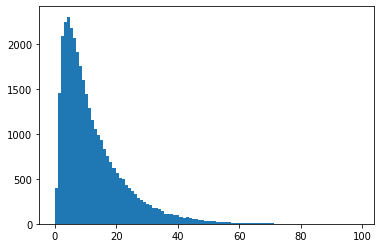

In [20]:
path = '../'
X_reg = np.load(path + 'X_6_new.npy')
y_reg = np.load(path + 'y_6_new.npy')


In [23]:
lower = 1
upper = 40

half_diff = (upper - lower) / 2
mid = lower + half_diff

idx = np.where(np.abs(y_reg - mid) >= half_diff)
X_reg = X_reg[idx]
y_reg = y_reg[idx]

y = np.zeros(y_reg.shape)
y[y_reg > upper] = 1

In [24]:
# XGBoost
from sklearn.ensemble import RandomForestClassifier

states = np.arange(1, 10, 1)
rocs_v = []
rocs_tr = []

for state in states:
    X_train, y_train, X_val, y_val, X_test, y_test, _, _ = train_test_split(X_reg, y, seed=state+10)
    clf = RandomForestClassifier(max_depth=6, random_state=10)
    clf.fit(X_train, y_train)
    predict_tr = clf.predict_proba(X_train)[:, 1]
    predict_val = clf.predict_proba(X_val)[:, 1]
    rocs_tr.append(classification_metrics(y_train, predict_tr))
    rocs_v.append(classification_metrics(y_val, predict_val))
rocs_tr = np.array(rocs_tr)
print(np.mean(rocs_tr))
print(np.std(rocs_tr))
rocs_v = np.array(rocs_v)
print(np.mean(rocs_v))
print(np.std(rocs_v))

0.8956497806922853
0.0044186148011786846
0.652302858913172
0.025813521540830785


In [ ]:
# XGBoost
from sklearn.ensemble import RandomForestClassifier

states = np.arange(1, 5, 1)
rocs = []
for state in states:
    X_train, y_train, X_val, y_val, X_test, y_test, _, _ = train_test_split(X, y, seed=state+10)
    clf = RandomForestClassifier(max_depth=15, random_state=10)
    clf.fit(X_train, y_train)

    predict_val = clf.predict_proba(X_val)[:, 1]

    rocs.append(classification_metrics(y_val, predict_val))
rocs = np.array(rocs)
print(np.mean(rocs))
print(np.std(rocs))

In [63]:

columns

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71])

In [60]:
idx = 

np.round(np.mean(x_stat[:, 0:18], axis=0), decimals=1)

array([0.6, 0.8, 1. , 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 6.4, 5.3, 2.8, 1.4,
       1.1, 1. , 1. , 1. , 1. ])

In [75]:
pts = '../data/processed/'
subdir = '6'
x_stat = np.load(pts + 'X_{}_stat.npy'.format(subdir))
x_dyn = np.load(pts + 'X_{}_dyn.npy'.format(subdir))
x_none = np.load(pts + 'X_{}_none.npy'.format(subdir))

#columns = np.concatenate((np.arange(0, 18, 1), np.arange(54, 54+18, 1)))
columns = [0, 9, 54, 63]
"""
print((np.round(np.mean(x_stat, axis=0) - np.mean(x_dyn, axis=0), decimals=1)))
print((np.round(np.mean(x_stat, axis=0) - np.mean(x_none, axis=0), decimals=1)))
print((np.round(np.mean(x_dyn, axis=0) - np.mean(x_none, axis=0), decimals=1)))
print(np.round(np.mean(x_stat, axis=0), decimals=1))
print(np.round(np.mean(x_dyn, axis=0), decimals=1))
"""

X = np.concatenate((x_stat[:, columns], x_none[:, columns]), axis=0)
y = np.zeros(X.shape[0])
y[0:x_stat.shape[0]] = 1

# XGBoost
from sklearn.ensemble import RandomForestClassifier

states = np.arange(1, 5, 1)
rocs = []
for state in states:
    X_train, y_train, X_val, y_val, X_test, y_test, _, _ = train_test_split(X, y, seed=state+10)
    clf = RandomForestClassifier(max_depth=8, random_state=10)
    clf.fit(X_train, y_train)

    predict_val = clf.predict_proba(X_val)[:, 1]

    rocs.append(classification_metrics(y_val, predict_val))
rocs = np.array(rocs)
print(np.mean(rocs))
print(np.std(rocs))

0.9647121026532737
0.002821515042331865


In [65]:
idx = np.random.permutation(x_none.shape[0])[0:x_stat.shape[0]]

#X = np.concatenate((x_stat[:, columns], x_dyn[:, columns]), axis=0)

#y[x_stat.shape[0]:x_stat.shape[0]+x_dyn.shape[0]] = 1

0.9002367907667493
0.004378716897885109


0.9599913922933
0.006491068828173514


In [ ]:
# Deep NN
X_train = torch.tensor(X_train, dtype=torch.double)
y_train = torch.tensor(y_train, dtype=torch.double).reshape(-1, 1)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test).reshape(-1, 1)
X_val = torch.tensor(X_val)
y_val = torch.tensor(y_val).reshape(-1, 1)

model = VanillaNN(in_dim=X_train.shape[1], out_dim=1, hidden_dims=[250, 250, 250])
criterion = nn.BCELoss()
optimiser = optim.SGD(model.parameters(), lr=0.05)
epochs = 5000
batch_size = 2000
print_freq = 250
for e in range(epochs):
    running_loss = 0
    
    X_batch, y_batch = sample_batch(X_train, y_train, batch_size)
    # setting gradient to zeros
    optimiser.zero_grad()        
    output = model(X_batch.float())
    loss = criterion(output.reshape(-1,1), y_batch.float().reshape(-1,1))
        
    # backward propagation
    loss.backward()
        
    # update the gradient to new gradients
    optimiser.step()
    running_loss += loss.item()
    
    if e % print_freq == 0:
        print("Epoch {}\t Training loss: {}".format(e, (running_loss/print_freq)))
        predict_train = model(X_train.float()).detach().numpy()
        predict_val = model(X_val.float()).detach().numpy()
        print(classification_metrics(y_train, predict_train))
        print(classification_metrics(y_val, predict_val))
        running_loss = 0

In [ ]:
pca = PCA(n_components=10)
transformed = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

In [ ]:
means1 = np.hstack(means)
vars1 = np.hstack(vars)

benchmark1 = np.hstack(benchmark)

In [ ]:
plt.scatter(y, means1, s=1)

In [ ]:

# i.e. a very skewed distribution of y values...

In [ ]:

y.shape

In [ ]:

plt.scatter(transformed[:, 0], y)

In [ ]:
train_mean = model(X_train.float())
test_mean = model(X_test.float())

In [ ]:
plt.scatter(y_test, test_mean.detach().numpy())

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
X = np.load('X5.npy')
y_reg = np.load('y5.npy')
threshold = 3
y = np.zeros(y_reg.shape)
y[y_reg > threshold] = 1
X_train, y_train, X_test, y_test, _, _ = train_test_split(X, y)

In [ ]:
clf = RandomForestClassifier(max_depth=25, random_state=0)
clf.fit(X_train, y_train)

In [ ]:
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_train, pred_train).ravel()
confusion_matrix(y_train, pred_train)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()
confusion_matrix(y_test, pred_test).ravel()

In [ ]:
tp